# Setup
2. Install TerraTorch

In [1]:
!pip install terratorch==0.99.9 gdown tensorboard


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings
import os
import zipfile

warnings.filterwarnings('ignore')

/home/jalmeida/.pyenv/versions/3.12.7/envs/sbsr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3. Download the dataset from Google Drive

In [7]:
if not os.path.isfile('granite-geospatial-biomass-dataset.zip'):
    !gdown 1k-SuberK2iq1NpiP1e9puNp7RVlg7I-X   

Downloading...
From (original): https://drive.google.com/uc?id=1k-SuberK2iq1NpiP1e9puNp7RVlg7I-X
From (redirected): https://drive.google.com/uc?id=1k-SuberK2iq1NpiP1e9puNp7RVlg7I-X&confirm=t&uuid=3d51d193-d933-4736-8ca0-b8a7d064cdc2
To: /home/jalmeida/Projetos/SBSR_courses/SBSR_notebooks/local/granite-geospatial-biomass-dataset.zip
100%|██████████████████████████████████████| 2.73G/2.73G [03:40<00:00, 12.4MB/s]


In [7]:
!ls

granite-geospatial-biomass-dataset.zip
prithvi_v2_eo_300_tl_unet_agb.ipynb
prithvi_v2_eo_300_tl_unet_agb.yaml
prithvi_v2_eo_300_tl_unet_burnscars.ipynb
prithvi_v2_eo_300_tl_unet_burnscars.yaml
prithvi_v2_eo_300_tl_unet_multitemporal_crop.ipynb
prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml
prithvi_v2_eo_300_tl_unet_sen1floods11.ipynb
requirements.txt


In [8]:
if not os.path.isdir('granite-geospatial-biomass-dataset/'):
    with zipfile.ZipFile('granite-geospatial-biomass-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('granite-geospatial-biomass-dataset')

## AGB Dataset

Lets start with analyzing the dataset

In [9]:
dataset_path = Path('granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset')
!ls "granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset"

test_images  test_labels  train_images	train_labels  val_images  val_labels


In [10]:
!ls "granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset/train_images/" | head

T11UPT_128_tile_img.tif
T11UPT_129_tile_img.tif
T11UPT_130_tile_img.tif
T11UPT_132_tile_img.tif
T11UPT_133_tile_img.tif
T11UPT_136_tile_img.tif
T11UPT_138_tile_img.tif
T11UPT_139_tile_img.tif
T11UPT_141_tile_img.tif
T11UPT_142_tile_img.tif
ls: erro de escrita: Pipe quebrado


In [11]:
datamodule = terratorch.datamodules.GenericNonGeoPixelwiseRegressionDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,
    check_stackability = False,
    # Define dataset paths 
    train_data_root=dataset_path / 'train_images/',
    train_label_data_root=dataset_path / 'train_labels/',
    val_data_root=dataset_path / 'val_images/',
    val_label_data_root=dataset_path / 'val_labels/',
    test_data_root=dataset_path / 'test_images/',
    test_label_data_root=dataset_path / 'test_labels/',
    
    img_grep='*.tif',
    label_grep='*.tif',
    
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
        
    # Define standardization values
    means=[
      547.36707,
      898.5121,
      1020.9082,
      2665.5352,
      2340.584,
      1610.1407,
    ],
    stds=[
      411.4701,
      558.54065,
      815.94025,
      812.4403,
      1113.7145,
      1067.641,
    ],
    dataset_bands = [-1, "BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2", -1, -1, -1, -1],
    output_bands = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    rgb_indices = [2, 1, 0],
    no_data_replace=0,
    no_label_replace=-1,
)

# Setup train and val datasets
datamodule.setup("fit")

In [12]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

1622

In [13]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

406

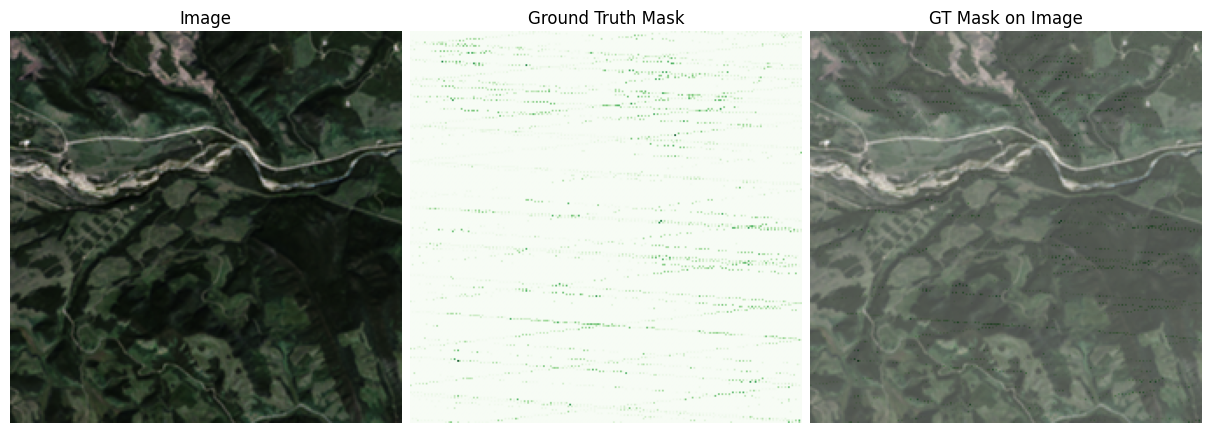

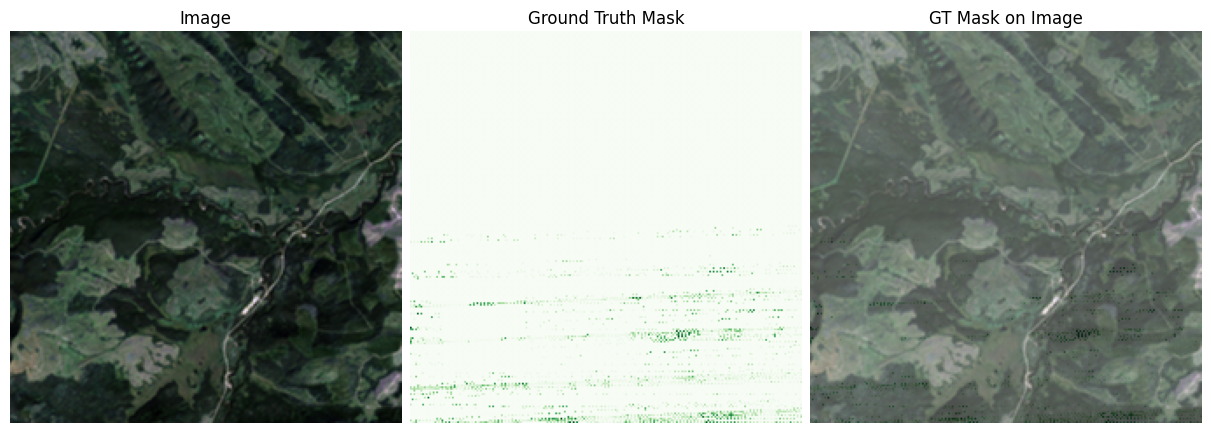

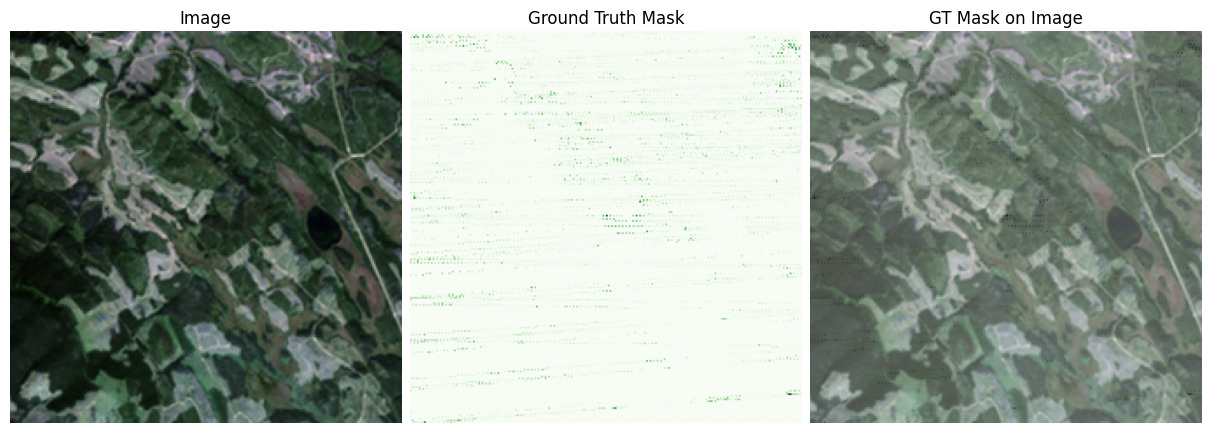

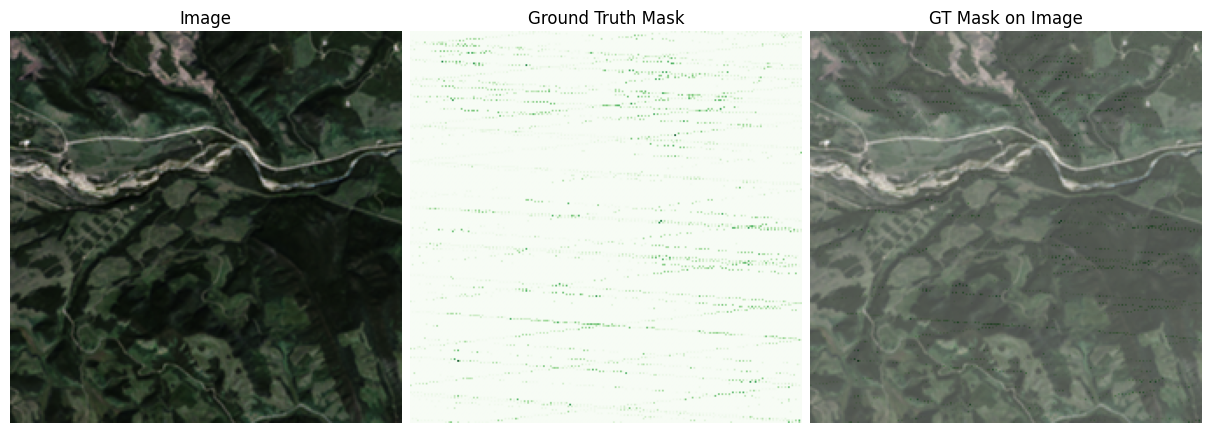

In [14]:
# plotting a few samples
val_dataset.plot(val_dataset[0])
val_dataset.plot(val_dataset[6])
val_dataset.plot(val_dataset[10])

In [15]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

360

# Fine-tune Prithvi

In [16]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/agb/checkpoints/",
    mode="min",
    monitor="val/RMSE", # Variable to monitor
    filename="best-{epoch:02d}",
)

from lightning.pytorch.callbacks import Callback


# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/agb",
    detect_anomaly=True,
)

# Model
model = terratorch.tasks.PixelwiseRegressionTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 1, # 1 is the default value,
        # "backbone_img_size": 224,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage",},
            {"name": "LearnedInterpolateToPyramidal"}            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        # "head_dropout": 0.16194593880230534,
        # "head_final_act": torch.nn.ReLU,
        # "head_learned_upscale_layers": 2
    },
    
    loss="rmse",
    optimizer="AdamW",
    lr=1e-3,
    ignore_index=-1,
    freeze_backbone=True, # Only to speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    # class_names=['no burned', 'burned']  # optionally define class names
)

Seed set to 0
Using bfloat16 Automatic Mixed Precision (AMP)
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


In [17]:
%load_ext tensorboard
%tensorboard --logdir output/multicrop

In [18]:
# Training
trainer.fit(model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  324 M │ train │
│ 1 │ criterion     │ RootLossWrapper  │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 20.3 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 324 M                                                                                                
Total estimated model params size (MB): 1.3 K                                                                      
Modules in train mode: 613                                                                                         
Modules in eval mode: 0

`Trainer.fit` stopped: `max_epochs=1` reached.


In [19]:
best_ckpt_path = "output/agb/checkpoints/best-epoch=00.ckpt"

In [20]:
def run_test_and_visual_inspection(model, ckpt_path):

    # let's run the model on the test set
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # now we can use the model for predictions and plotting!
    model = terratorch.tasks.PixelwiseRegressionTask.load_from_checkpoint(
    ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
    )
    
    test_loader = datamodule.test_dataloader()
    with torch.no_grad():
        batch = next(iter(test_loader))
        images = datamodule.aug(batch)
        images = batch["image"].to(model.device)
        
        masks = batch["mask"].numpy()
    
        preds = model(images).output
    
    for i in range(4):
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[i].cpu()
        sample["image"] = sample["image"].cpu()
        sample["mask"] = sample["mask"].cpu()
        test_dataset.plot(sample)

Restoring states from the checkpoint path at output/agb/checkpoints/best-epoch=00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at output/agb/checkpoints/best-epoch=00.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │     18.62490463256836     │
│         test/MSE          │    1174.8238525390625     │
│         test/RMSE         │     34.27570343017578     │
│         test/loss         │    32.263885498046875     │
└───────────────────────────┴───────────────────────────┘

INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


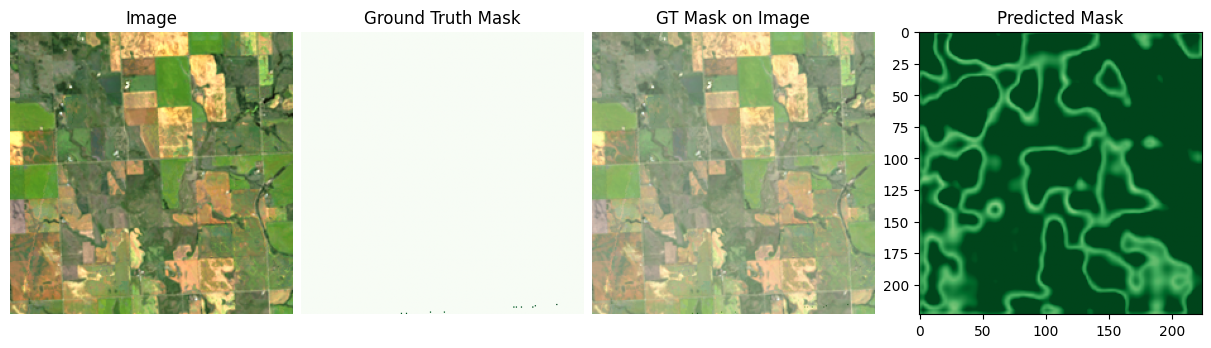

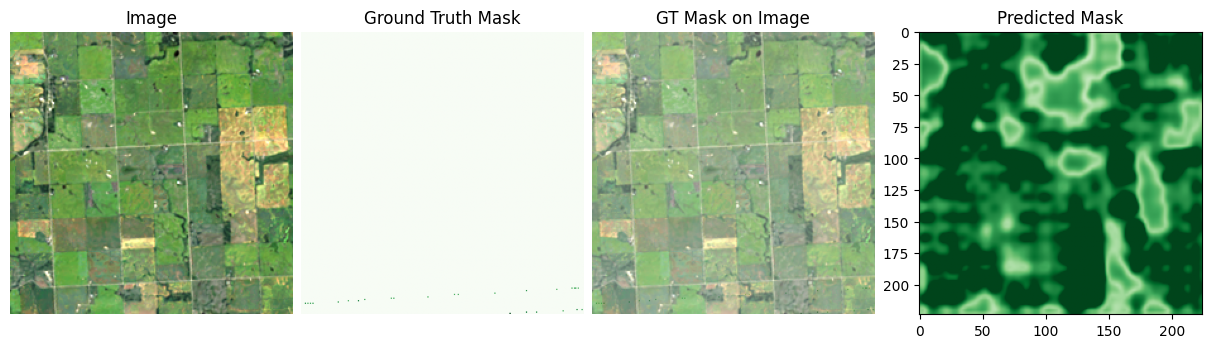

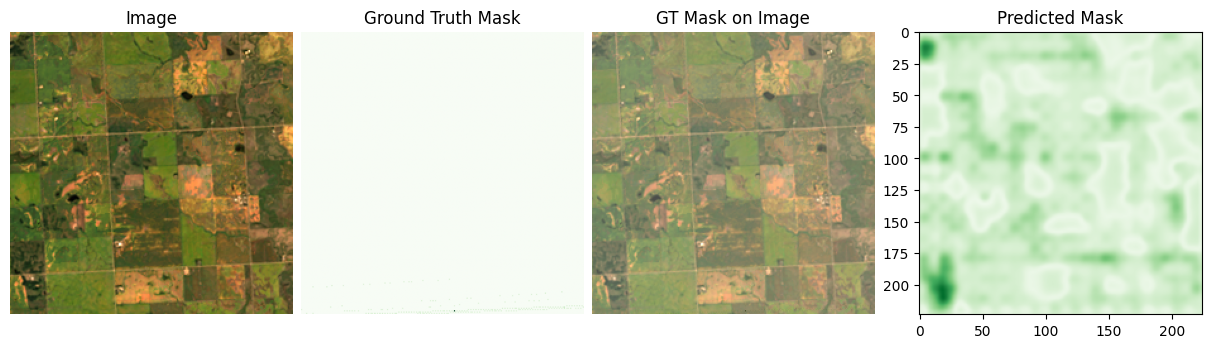

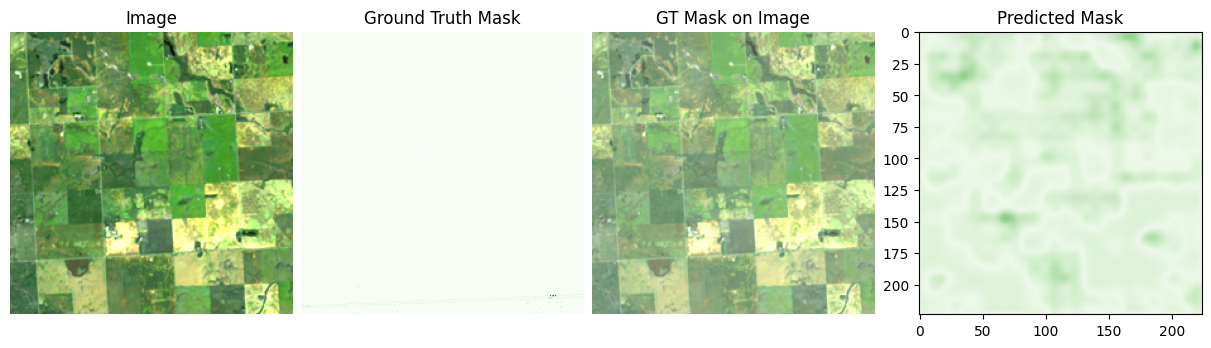

In [21]:
run_test_and_visual_inspection(model, best_ckpt_path)

In [22]:
best_ckpt_100_epoch_path = "agb_best-epoch=68.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1ACjb4oWb2p_ZA87TQcuSWvCcB4_61fA-")


Downloading...
From (original): https://drive.google.com/uc?id=1ACjb4oWb2p_ZA87TQcuSWvCcB4_61fA-
From (redirected): https://drive.google.com/uc?id=1ACjb4oWb2p_ZA87TQcuSWvCcB4_61fA-&confirm=t&uuid=44f7aabf-0479-4a77-904c-cf94e0318630
To: /home/jalmeida/Projetos/SBSR_courses/SBSR_notebooks/local/agb_best-epoch=68.ckpt
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.46G/1.46G [01:59<00:00, 12.3MB/s]


Restoring states from the checkpoint path at agb_best-epoch=68.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at agb_best-epoch=68.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    16.241424560546875     │
│         test/MSE          │     972.0464477539062     │
│         test/RMSE         │     31.17765998840332     │
│         test/loss         │     29.27315902709961     │
└───────────────────────────┴───────────────────────────┘

INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


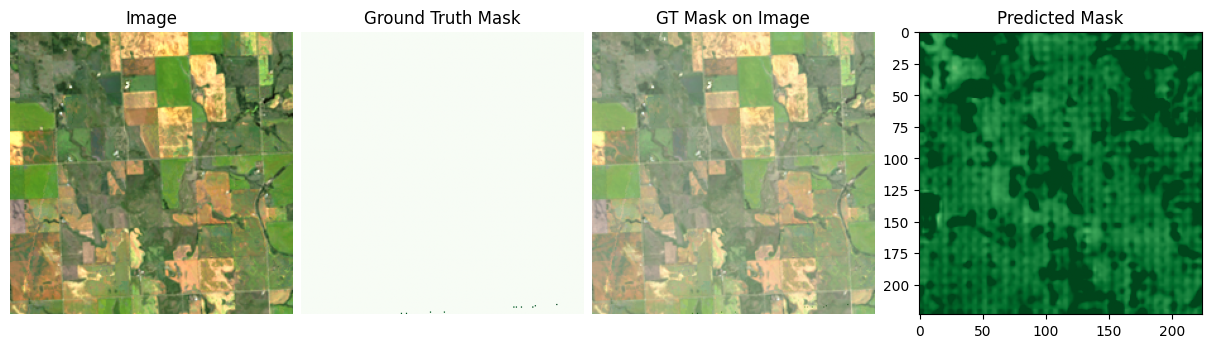

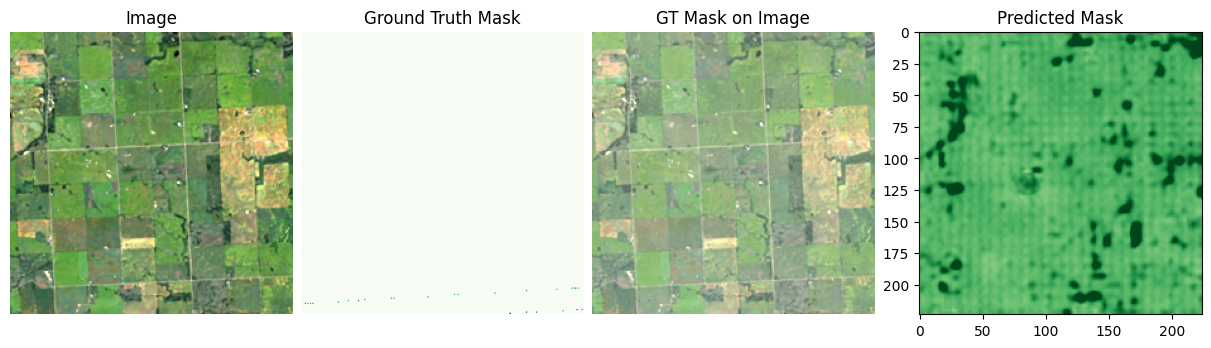

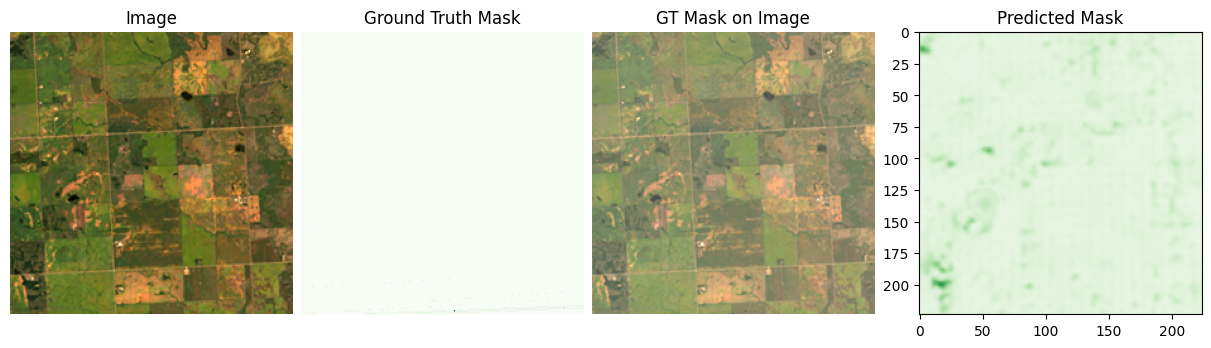

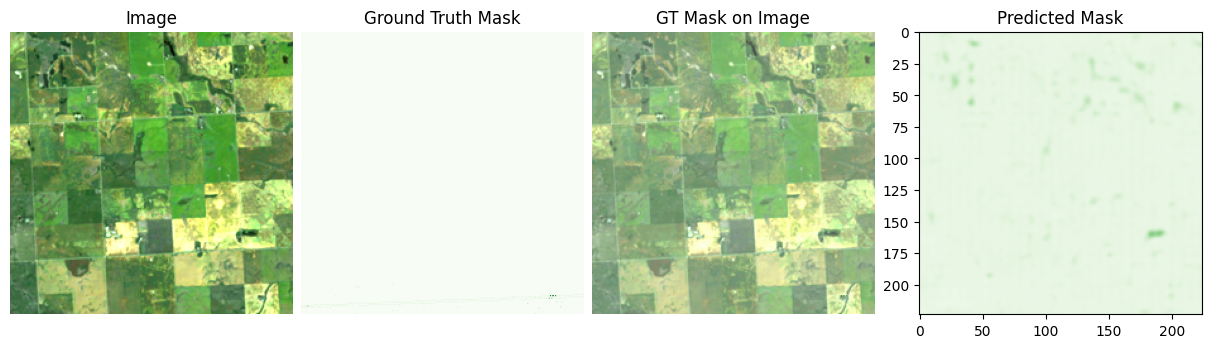

In [24]:
run_test_and_visual_inspection(model, best_ckpt_100_epoch_path)